In [1]:
import os
os.chdir("../")

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dataset import load_dataset

/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

In [4]:
dataset = load_dataset("/ravana/d3d_work/micorl/data/ct_images_prostate_32fixed/")

Loading dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


In [5]:
import torch
from torch.utils.data import DataLoader

In [6]:
train_len = int(0.9 * len(dataset))
val_len = len(dataset) - train_len

In [7]:
train_loader = DataLoader(
    dataset[:train_len],
    batch_size=3,
    num_workers=8,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
    )
        # 

/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
import math
# (0.1*len(dataset))

In [9]:

val_loader = DataLoader(
    dataset[:val_len],
    batch_size=3,
    num_workers=8,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
    )

In [10]:
real_batch = next(iter(train_loader))

In [11]:
real_batch.shape

torch.Size([3, 1, 256, 256, 32])

In [12]:
real_batch[0].shape

torch.Size([1, 256, 256, 32])

In [13]:
from src.utils import plot_dicom

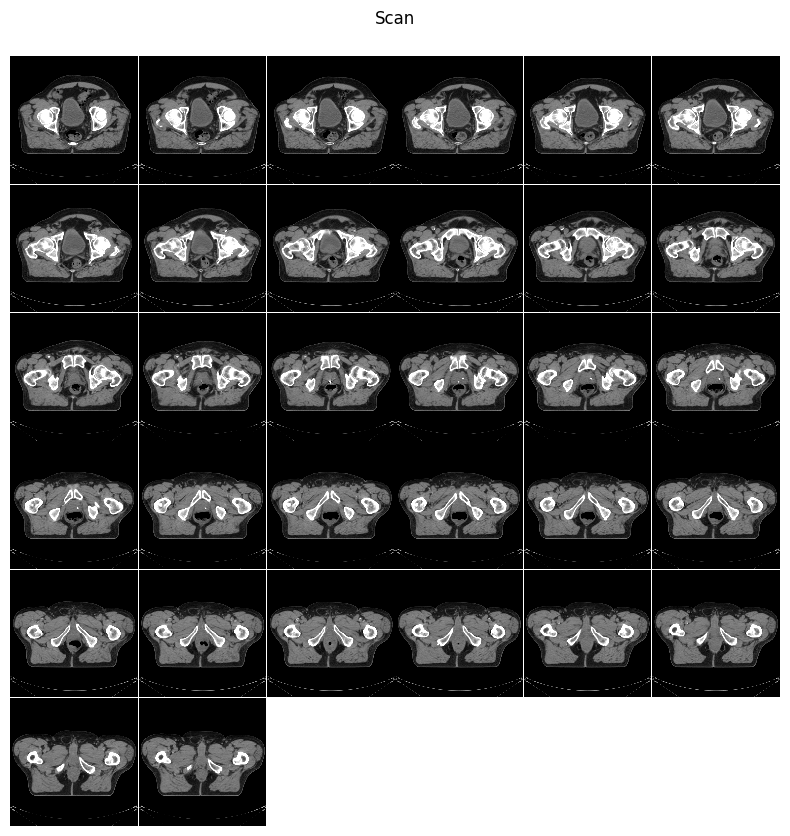

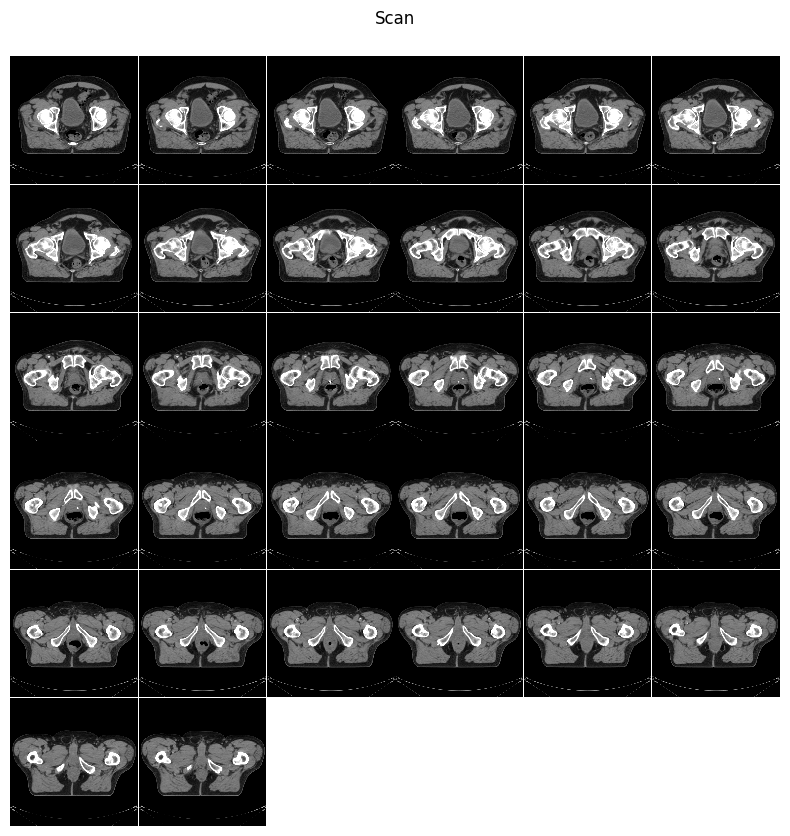

In [14]:
plot_dicom(real_batch[0][0])

# Monai Gen

In [15]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.cuda.amp import autocast
from tqdm import tqdm


In [16]:
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, PatchDiscriminator

In [20]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"Using {device}")


Using cpu


In [21]:
torch.cuda.is_available()

False

In [22]:
torch.zeros(1).to(device)

tensor([0.])

In [23]:

model = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=(256, 256, 32),
    latent_channels=3,
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
model.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv3d(1, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (1): ResBlock(
        (norm1): GroupNorm(32, 256, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (norm2): GroupNorm(32, 256, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (nin_shortcut): Identity()
      )
      (2): Downsample(
        (conv): Convolution(
          (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2))
        )
      )
      (3): ResBlock(
        (norm1): GroupNorm(32, 256, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        

In [24]:
discriminator = PatchDiscriminator(
    spatial_dims=3,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1), bias=Fal

In [25]:
perceptual_loss = PerceptualLoss(spatial_dims=3, network_type="squeeze", fake_3d_ratio=0.25)
perceptual_loss.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

optimizer_g = torch.optim.Adam(model.parameters(), 1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [27]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 6
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer_g.zero_grad(set_to_none=True)

        # Generator part
        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = model(images)
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)

            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3, 4])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss) + (adv_weight * generator_loss)

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        # Discriminator part
        optimizer_d.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

        scaler_d.scale(loss_d).backward()
        scaler_d.step(optimizer_d)
        scaler_d.update()

        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(train_loader, start=1):
                images = batch["image"].to(device)
                optimizer_g.zero_grad(set_to_none=True)

                reconstruction, z_mu, z_sigma = model(images)
                # get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = F.l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

progress_bar.close()

Epoch 0:   0%|                                  | 0/9 [00:00<?, ?it/s]

/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
